In [1]:
import numpy as np
from statsmodels.tsa.api import VAR
import tensorflow as tf
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
node = [1,2,3,4,5,6,7,8,9,12,13]
start = datetime.datetime.strptime("2018-08-27", "%Y-%m-%d")
end = datetime.datetime.strptime("2018-9-27", "%Y-%m-%d")
date = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

### Vector Autoregressions

In [3]:
def combine(data, slots=6):
    result = []
    for arr in data:
        result.append(calculate(arr, slots))

    return np.array(result)

def calculate(arr, slots):
    length = arr.shape[0]
    result = []
    for i in range(0, length, slots):
        tmp = arr[i:i + 6]
        tmp_mean = np.mean(tmp[:, 0:11], axis=0)
        tmp_median = np.median(tmp[:, 11:22], axis=0)
        tmp_max = np.max(tmp[:, 22:33], axis=0)
        tmp_min = np.min(tmp[:, 33:44], axis=0)
        tmp = ans = np.hstack((tmp_mean, tmp_median, tmp_max, tmp_min))
        result.append(tmp)

    return np.array(result)

def concatenate(date_list, node):
    data = []
    for date in date_list:
        if date.weekday() >= 5:
            continue
        tmp = np.load("./data/m4/" + str(date)[:10] + '_4.npy')
        if tmp.shape[0] < 286:
            continue
        data.append(tmp)
    return np.array(data)

In [4]:
class Data:

    def __init__(self, time, batch_size = 36):
        self.odata = concatenate(date_list=date, node=node)
        self.data = None
        self.data_init(miniute=5, time=10)
        self.data = combine(self.data)

        self.length = len(self.data)

        self.train_len = int(self.length * 0.8)
        self.val_len = int(self.length - self.train_len)

        self.index = None
        self.train_index = None
        self.train_pos = 0
        self.val_index = None
        self.val_pos = 0
        self.batch_size = batch_size

    def data_init(self, miniute, time):
        data = self.odata
        result = []
        start = int(9 * 60 / miniute)
        for i in range(start, 286 - 42, int(time / miniute)):
            result.append(data[:, i:i + 42, :])
        self.data =  np.array(result).reshape(-1, 42, 44)
            
    def reset_index(self):
        self.index = np.arange(self.length)
        
    def shuffle_index(self):
        self.train_pos = 0
        self.val_pos = 0
        np.random.shuffle(self.index)
        self.train_index = self.index[:self.train_len]
        self.val_index = self.index[self.train_len:]

    def get_train(self):
        train = self.data[self.train_index[self.train_pos:  self.train_pos + self.batch_size]][:, 0:-1]
        label = self.data[self.train_index[self.train_pos: self.train_pos + self.batch_size]][:, 1:, 0:11]
        self.train_pos += self.batch_size
        
        return train, label

    def get_val(self):
        train = self.data[self.val_index[self.val_pos: self.val_pos + self.batch_size]][:, 0:-1]
        label = self.data[self.val_index[self.val_pos: self.val_pos + self.batch_size]][:, 1:, 0:11]
        self.val_pos += self.batch_size

        return train, label

In [5]:
data = combine(concatenate(date_list=date, node=node))
data = data.reshape(-1, 44)
model = VAR(data)
model_fit = model.fit(6)

In [6]:
pred_data = combine(np.load("./data/m4/2018-10-02_4.npy").reshape(-1, 286, 44))
pred = pred_data.reshape(-1, 44)

In [6]:
a = Data(10)

In [22]:
num_input = 44
num_time_step = 6
# num_neuron_per_layer = 256
num_neuron_per_layer = 512
num_layers = 1
num_output = 11
learning_rate = 0.001
nepoches = 150

tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=[None, num_time_step, num_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, num_time_step, num_output])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neuron_per_layer, activation=tf.nn.relu)
cell = tf.contrib.rnn.AttentionCellWrapper(cell, attn_length=6)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, num_output)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(y - outputs))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()
a.reset_index()

# with tf.Session() as sess:
#     sess.run(init)
#     f = open("log_10min_128_2_dropout.txt", "w")
#     for epoch in range(nepoches):
#         iteration = a.train_len // a.batch_size
#         a.shuffle_index()
#         for i in range(iteration):
#             x_batch, y_batch = a.get_train()
#             sess.run(train, feed_dict={X:x_batch, y:y_batch})
        
#         if epoch % 10 == 0:
#             x_batch, y_batch = a.get_val()
#             mse = loss.eval(feed_dict={X:x_batch, y:y_batch})
#             print (epoch, "\tMSE:", mse)
#             f.write(str(epoch) + "\tMSE:" + str(mse))
#     f.close()
#     saver.save(sess, "./RNN_MODEL_10_128_2_dropout")

In [11]:
pred_10_2 = combine(np.load("./data/m4/2018-10-02_4.npy").reshape(-1, 286, 44))
pred_10_8 = combine(np.load("./data/m4/2018-10-08_4.npy").reshape(-1, 286, 44))
pred_10_11 = combine(np.load("./data/m4/2018-10-11_4.npy").reshape(-1, 286, 44))
pred_all = np.array([pred_10_2, pred_10_8, pred_10_11])

In [34]:
result = []
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./RNN_MODEL_10_att_128130")
    for pred in pred_all:
        pos = 18
        tmp = []
        pred = pred.reshape(-1, 44)
        for i in range(25):
            x_batch = pred[pos:pos + 6].reshape(1, num_time_step, 44)
            y_pred = sess.run(outputs, feed_dict={X:x_batch})
            tmp.append(y_pred[0][5])
            pos += 1
        result.append(np.array(tmp))
    np.save("result_10min_att_512.npy", np.array(result))

INFO:tensorflow:Restoring parameters from ./RNN_MODEL_10_att_128130


### Build Vector Autoregression Model with p = 6 (3 hrs to predict next half hour)


$VAR(p) : $
$y_t = c + A_1*y_{t-1} + A_2*y_{t-2} + *** + A_p*y_{t-p}$

In [34]:
data = combine(concatenate(date_list=date, node=node))
data = data.reshape(-1, 44)
model = VAR(data)
model_fit = model.fit(6)

In [258]:
result = []
for pred in pred_all:
    tmp = []
    pos = 18
    pred = pred.reshape(-1, 44)
    for i in range(25):
        x_batch = pred[pos:pos + 6]
        y_pred = model_fit.forecast(x_batch, 1)
        tmp.append(y_pred[0])
        pos += 1
    result.append(np.array(tmp))

np.save("result_VAR.npy", np.array(result))

### Load Data and Show resu

In [128]:
result_5min = np.load("./result_5min.npy")
result_10min = np.load("./result_10min.npy")
result_15min = np.load("./result_15min.npy")
result_10min_128_2 = np.load("./result_10min_128_2.npy")
result_10min_128_2_tanh = np.load("./result_10min_128_2_tanh.npy")
result_10min_128_1 = np.load("./result_10min_128_1.npy")
result_10min_128_2_dropout = np.load("./result_10min_128_2_dropout.npy")
result_VAR = np.load("./result_VAR.npy")

In [15]:
def mse(pred, gt):
    return np.mean(np.square(pred - gt))

def Rsquare(pred, gt):
    length = len(pred)
    result = 0
    for i in range(length):
        result += r2_score(pred[i], gt[i])
    return result / length

### MSE for VAR

In [139]:
mse_VAR = mse(result_VAR[:, :24, :11], gt=pred_all[:, 0, 24:, :11])
r2_VAR = Rsquare(result_VAR[:, :24, :11], gt=pred_all[:, 0, 24:, :11])
print("MSE", str(mse_VAR))
print("R-square", str(r2_VAR))

MSE 76.92108665966082
R-square 0.6880854926814264


### MSE for 15min (2 X)

In [140]:
mse_15min = mse(result_15min[:, :24], gt=pred_all[:, 0, 24:, :11])
r2_15min = Rsquare(result_15min[:, :24], gt=pred_all[:, 0, 24:, :11])
print("MSE", str(mse_15min))
print("R-square", str(r2_15min))

MSE 37.898855053087836
R-square 0.8650168324357725


### MSE for 10min (4 X)

In [141]:
mse_10min = mse(result_10min[:, :24], gt=pred_all[:, 0, 24:, :11])
r2_10min = Rsquare(result_10min[:, :24], gt=pred_all[:, 0, 24:, :11])
print("MSE", str(mse_10min))
print("R-square", str(r2_10min))

MSE 28.363363418387262
R-square 0.921748616131408


### Attention and Early Stop

In [32]:
result_10min_es = np.load("./result_10min_att_512.npy")
mse_10min_es = mse(result_10min_es[:, :24], gt=pred_all[:, 0, 24:, :11])
r2_10min_es = Rsquare(result_10min_es[:, :24], gt=pred_all[:, 0, 24:, :11])
print("MSE", str(mse_10min_es))
print("R-square", str(r2_10min_es))

MSE 24.205649473356154
R-square 0.927301846981918


### Wavelet Transfrom

In [36]:
result_10min_wl = np.load("./result_10min_att_wl_512_100.npy")
mse_10min_wl = mse(result_10min_wl[:, :24], gt=pred_all[:, 0, 24:, :11])
r2_10min_wl = Rsquare(result_10min_wl[:, :24], gt=pred_all[:, 0, 24:, :11])
print("MSE", str(mse_10min_wl))
print("R-square", str(r2_10min_wl))

MSE 25.252518847240026
R-square 0.9251534581701447


### Add stack LSTMs with same neurons

In [143]:
mse_10min_128_2 = mse(result_10min_128_2[:, :24], gt=pred_all[:, 0, 24:, :11])
r2_10min_128_2 = Rsquare(result_10min_128_2[:, :24], gt=pred_all[:, 0, 24:, :11])
print("MSE"e, str(mse_10min_128_2))
print("R-square", str(r2_10min_128_2))

MSE 34.45331152925666
R-square 0.8859970417374688


### Change activation function to tanh

In [56]:
mse_10min_128_2_tanh = mse(result_10min_128_2_tanh[:, :24], gt=pred_all[:, 0, 24:, :11])
print(mse_10min_128_2_tanh)

66909813.856692486


### Reduce size of neuron from 256 to 128

In [66]:
mse_10min_128_1 = mse(result_10min_128_1[:, :24], gt=pred_all[:, 0, 24:, :11])
print(mse_10min_128_1)

45.30876174363136


### Add dropout

In [76]:
mse_10min_128_2_dropout_1_7 = mse(result_10min_128_2_dropout[:, :24], gt=pred_all[:, 0, 24:, :11])
print(mse_10min_128_2_dropout_1_7)

53.354547799039274


### MSE for 5min (10 X )

In [45]:
mse_5min = mse(result_5min[:, :24], gt=pred_all[:, 0, 24:, :11])
print(mse_5min)

35.839166243043024


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

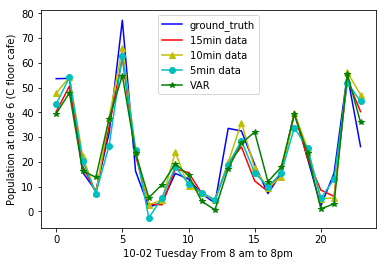

In [31]:
plt.figure(0)
plt.plot(pred_10_2[0, 24:, 5], "b")
plt.plot(result_15min[0, :24, 5], 'r')
plt.plot(result_10min[0, :24, 5], 'y^-')
plt.plot(result_5min[0, :24, 5], 'co-')
plt.plot(result_VAR[0, :24, 5], 'g*-')
plt.xlabel("10-02 Tuesday From 8 am to 8pm")
plt.ylabel("Population at node 6 (C floor cafe)")
plt.legend(["ground_truth", "15min data", "10min data", "5min data", "VAR"])

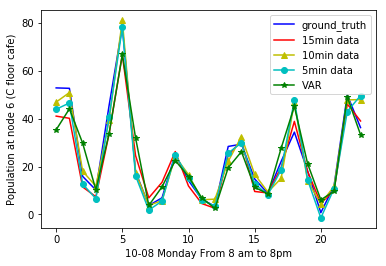

In [32]:
plt.figure(3)
plt.plot(pred_10_8[0, 24:, 5], "b")
plt.plot(result_15min[1, :24, 5], 'r')
plt.plot(result_10min[1, :24, 5], 'y^-')
plt.plot(result_5min[1, :24, 5], 'co-')
plt.plot(result_VAR[1, :24, 5], 'g*-')
plt.xlabel("10-08 Monday From 8 am to 8pm")
plt.ylabel("Population at node 6 (C floor cafe)")
plt.legend(["ground_truth", "15min data", "10min data", "5min data", "VAR"])

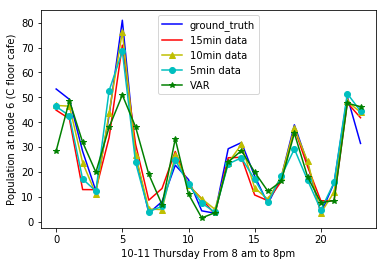

In [33]:
plt.figure(5)
plt.plot(pred_10_11[0, 24:, 5], "b")
plt.plot(result_15min[2, :24, 5], 'r')
plt.plot(result_10min[2, :24, 5], 'y^-')
plt.plot(result_5min[2, :24, 5], 'co-')
plt.plot(result_VAR[2, :24, 5], 'g*-')
plt.xlabel("10-11 Thursday From 8 am to 8pm")
plt.ylabel("Population at node 6 (C floor cafe)")
plt.legend(["ground_truth", "15min data", "10min data", "5min data", "VAR"])